In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

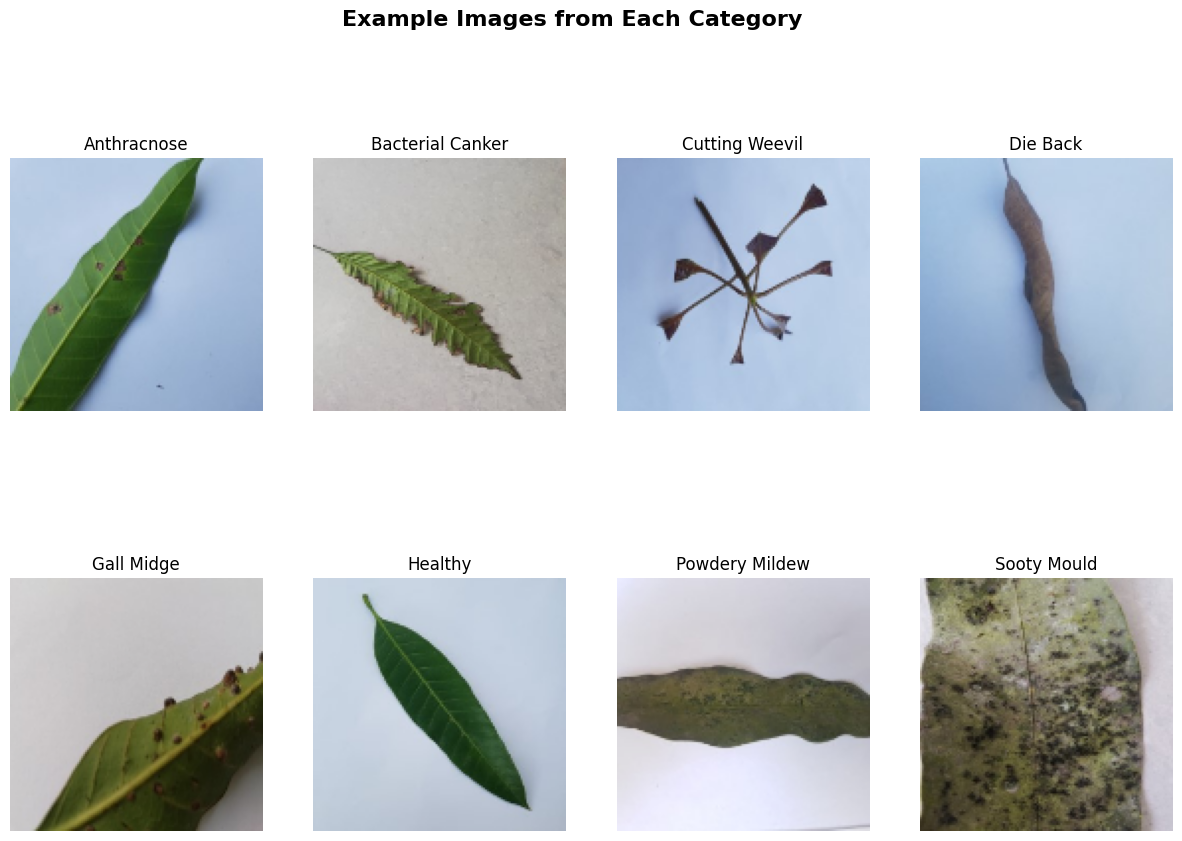

In [ ]:
data_dir = '/content/drive/MyDrive/Mango Dataset/MangoLeafBD Dataset'
categories = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
              "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

# Function to load images, labels, and average colors
def load_images(data_dir, categories, img_size=(128, 128)):
    images, labels, avg_colors = [], [], []
    for label, category in enumerate(categories):
        path = os.path.join(data_dir, category)
        if not os.path.isdir(path):
            print(f"Directory not found: {path}")
            continue
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
                avg_colors.append(cv2.mean(img)[:3])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels), np.array(avg_colors)

images, labels, avg_colors = load_images(data_dir, categories)

# Display images from each category
def display_sample_images(images, labels, categories):
    plt.figure(figsize=(15, 10))
    for i in range(len(categories)):
        plt.subplot(2, 4, i+1)
        category_images = images[labels == i]
        plt.imshow(cv2.cvtColor(category_images[0], cv2.COLOR_BGR2RGB))
        plt.title(categories[i], fontsize=12)
        plt.axis('off')
    plt.suptitle("Example Images from Each Category", fontsize=16, fontweight='bold')
    plt.show()

display_sample_images(images, labels, categories)

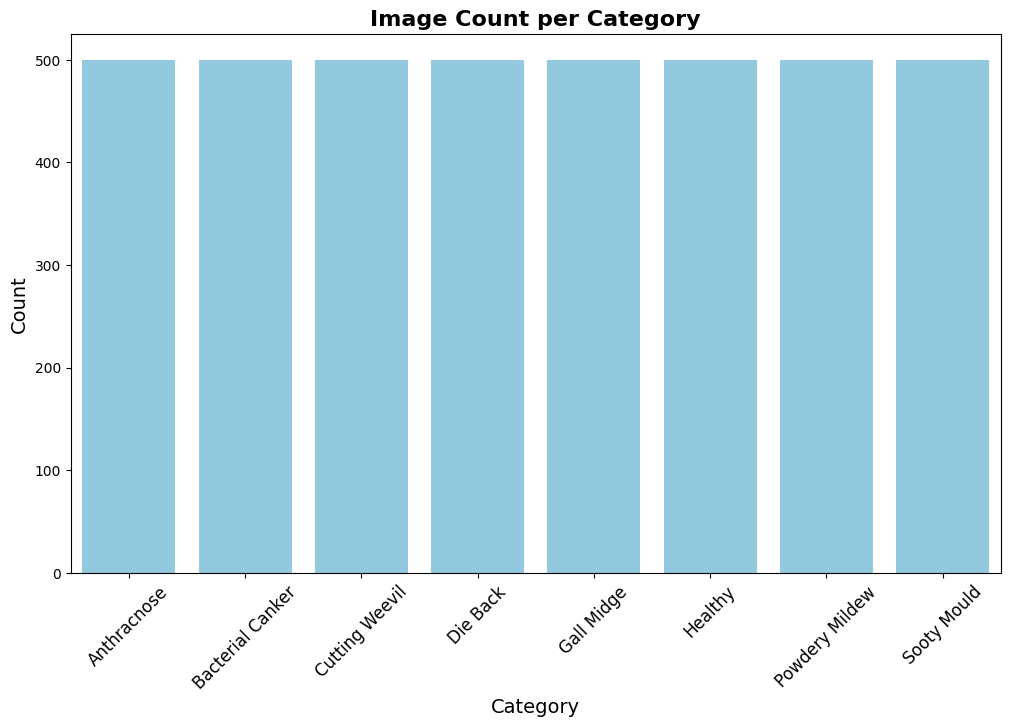

In [ ]:
# EDA

# Display Category Distribution
category_counts = Counter(labels)
plt.figure(figsize=(12, 7))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()), color='skyblue')
plt.xticks(range(len(categories)), categories, rotation=45, fontsize=12)
plt.title('Image Count per Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()


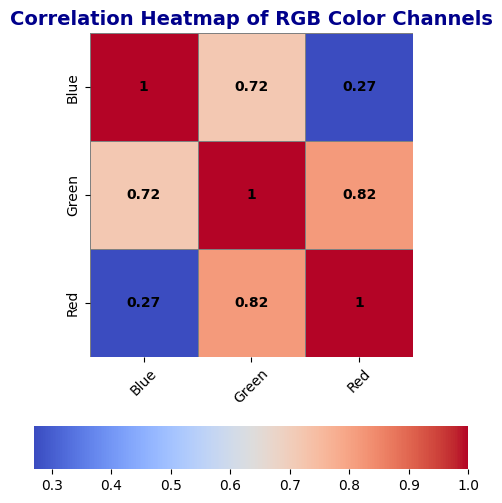

In [ ]:
# Color Correlation Heatmap for RGB Channels
color_df = pd.DataFrame(avg_colors, columns=['Blue', 'Green', 'Red'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    color_df.corr(),
    annot=True,
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'shrink': 0.7, 'aspect': 10, 'orientation': 'horizontal'},
    annot_kws={'size': 10, 'weight': 'bold', 'color': 'black'}
)

plt.title("Correlation Heatmap of RGB Color Channels", fontsize=14, fontweight='bold', color='darkblue')
plt.xticks(fontsize=10, rotation=45, color='black')
plt.yticks(fontsize=10, color='black')
plt.show()

In [ ]:
# Summary Table with Average Color Intensity by Category
summary_data = {
    "Category": categories,
    "Image Count": [category_counts[cat] for cat in range(len(categories))],
    "Avg Blue": [np.mean(avg_colors[labels == cat, 0]) for cat in range(len(categories))],
    "Avg Green": [np.mean(avg_colors[labels == cat, 1]) for cat in range(len(categories))],
    "Avg Red": [np.mean(avg_colors[labels == cat, 2]) for cat in range(len(categories))]
}
summary_df = pd.DataFrame(summary_data)
styled_summary_df = summary_df.style \
    .background_gradient(subset=['Avg Blue'], cmap="Blues") \
    .background_gradient(subset=['Avg Green'], cmap="Greens") \
    .background_gradient(subset=['Avg Red'], cmap="Reds") \
    .set_caption("Category Summary Table")

display(styled_summary_df)


,Category,Image Count,Avg Blue,Avg Green,Avg Red
0,Anthracnose,500,177.381043,181.291865,175.884111
1,Bacterial Canker,500,161.357619,173.474733,174.161276
2,Cutting Weevil,500,198.101516,176.394646,152.015702
3,Die Back,500,188.665198,171.646450,160.609038
4,Gall Midge,500,171.364578,179.479750,180.386189
5,Healthy,500,173.119382,184.125183,180.827063
6,Powdery Mildew,500,164.235554,168.028189,166.434599
7,Sooty Mould,500,162.735904,175.105250,175.701873


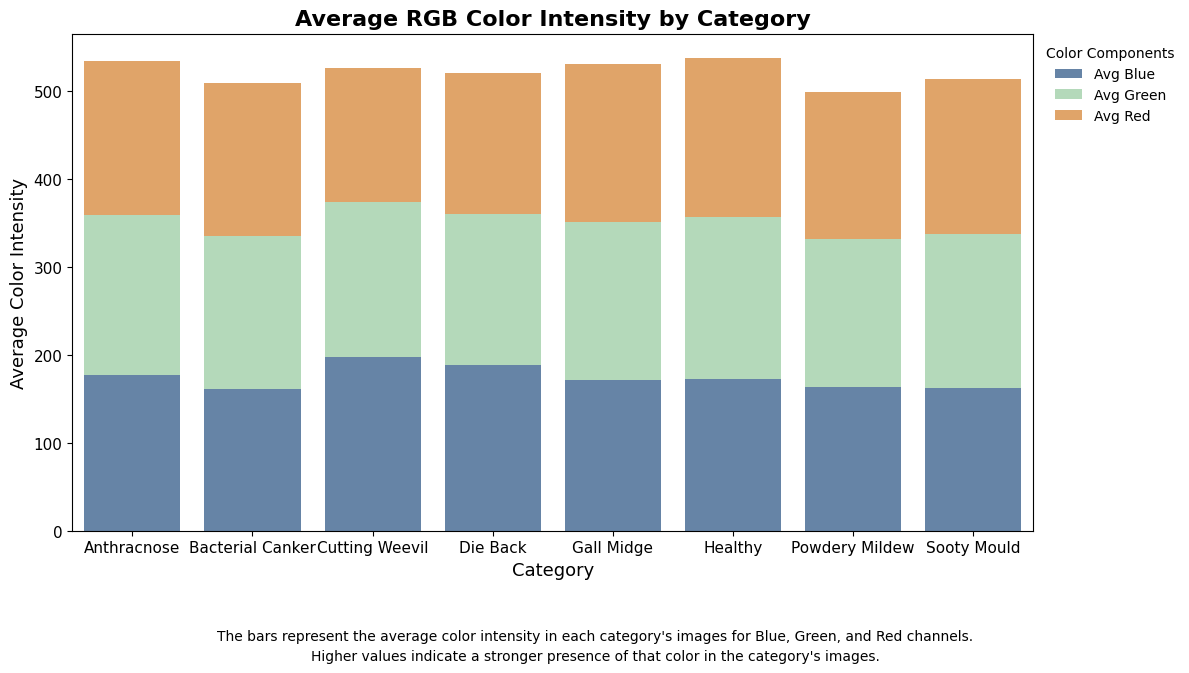

In [ ]:
# Average Color Intensity by Category (RGB)
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Avg Blue', data=summary_df, color='#5B84B1FF', label="Avg Blue")
sns.barplot(x='Category', y='Avg Green', data=summary_df, color='#A0DAA9FF', label="Avg Green", alpha=0.85, bottom=summary_df["Avg Blue"])
sns.barplot(x='Category', y='Avg Red', data=summary_df, color='#F28E2B', label="Avg Red", alpha=0.8, bottom=summary_df["Avg Blue"] + summary_df["Avg Green"])

plt.title("Average RGB Color Intensity by Category", fontsize=16, color='black', fontweight='bold')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Color Components", frameon=False)
plt.xlabel("Category", fontsize=13, color='black')
plt.ylabel("Average Color Intensity", fontsize=13, color='black')
plt.xticks(rotation=0, fontsize=11, color='black')
plt.yticks(fontsize=11, color='black')

description_text = (
    "The bars represent the average color intensity in each category's images for "
    "Blue, Green, and Red channels.\nHigher values indicate a stronger presence "
    "of that color in the category's images."
)
plt.figtext(0.5, -0.1, description_text, wrap=True, ha="center", fontsize=10, color="black", linespacing=1.5)
plt.tight_layout()
plt.show()

In [ ]:
# Model Training

flat_images = images.reshape(len(images), -1)

X_train, X_test, y_train, y_test = train_test_split(flat_images, labels, test_size=0.3, random_state=42)

def evaluate_model(model, X_train, X_test, y_train, y_test, categories):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, labels=np.arange(len(categories)), target_names=categories, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    print(report)
    print(f"Overall Accuracy: {accuracy:.2f}\n")
    return report, accuracy

def plot_confusion_matrix(y_true, y_pred, categories, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

Decision Tree Performance:
                  precision    recall  f1-score   support

     Anthracnose       0.71      0.66      0.68       167
Bacterial Canker       0.75      0.70      0.72       148
  Cutting Weevil       0.91      0.93      0.92       158
        Die Back       0.84      0.85      0.84       149
      Gall Midge       0.48      0.59      0.53       159
         Healthy       0.64      0.55      0.59       135
  Powdery Mildew       0.62      0.62      0.62       134
     Sooty Mould       0.53      0.52      0.52       150

        accuracy                           0.68      1200
       macro avg       0.68      0.68      0.68      1200
    weighted avg       0.69      0.68      0.68      1200

Overall Accuracy: 0.68

Confusion Matrix for Decision Tree:


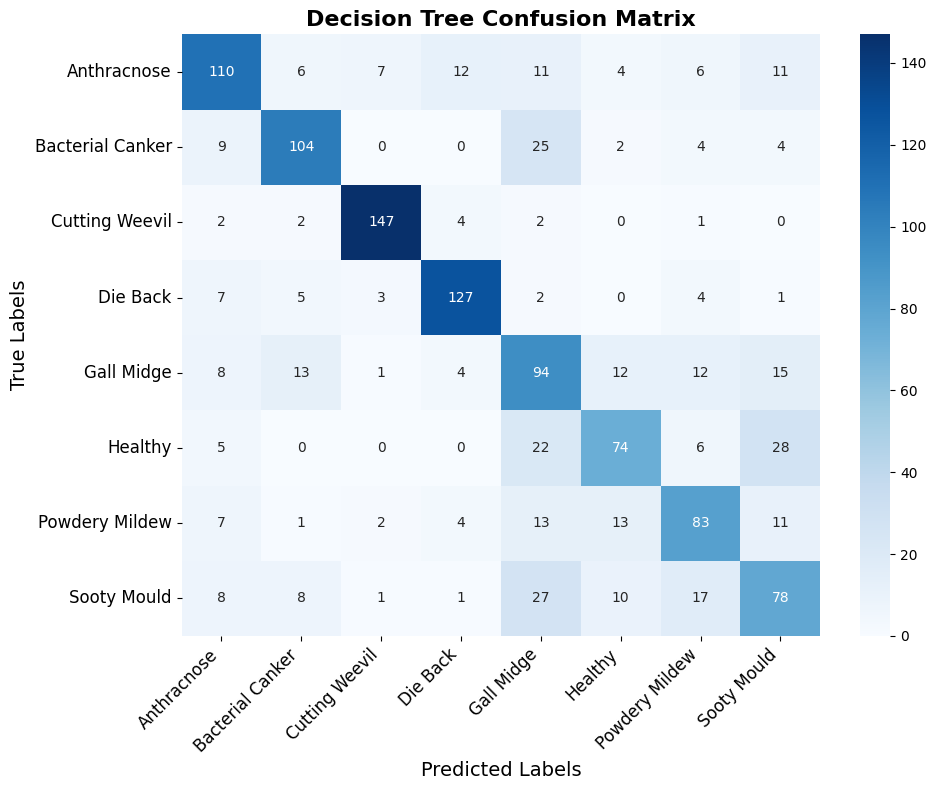

In [ ]:
print("Decision Tree Performance:")
dt_report, dt_accuracy = evaluate_model(dt_model, X_train, X_test, y_train, y_test, categories)
print("Confusion Matrix for Decision Tree:")
plot_confusion_matrix(y_test, dt_model.predict(X_test), categories, title="Decision Tree Confusion Matrix")

Random Forest Performance:
                  precision    recall  f1-score   support

     Anthracnose       0.85      0.86      0.85       167
Bacterial Canker       0.82      0.78      0.80       148
  Cutting Weevil       0.97      0.96      0.97       158
        Die Back       0.91      0.95      0.93       149
      Gall Midge       0.70      0.76      0.73       159
         Healthy       0.90      0.89      0.90       135
  Powdery Mildew       0.86      0.84      0.85       134
     Sooty Mould       0.79      0.75      0.77       150

        accuracy                           0.85      1200
       macro avg       0.85      0.85      0.85      1200
    weighted avg       0.85      0.85      0.85      1200

Overall Accuracy: 0.85

Confusion Matrix for Random Forest:


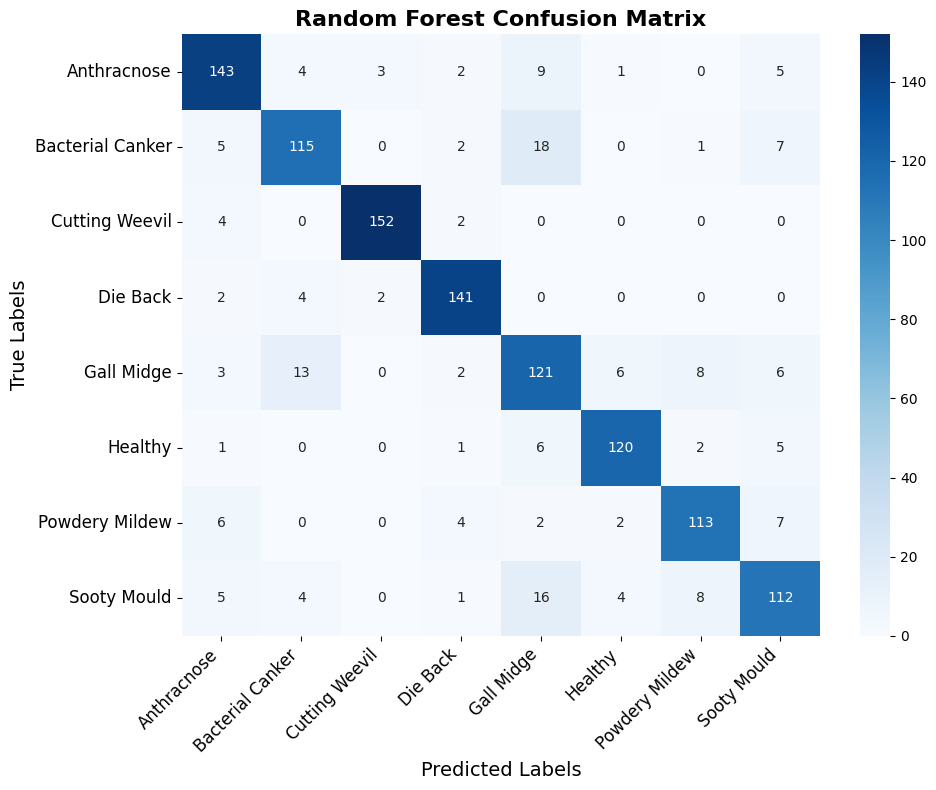

In [ ]:
print("Random Forest Performance:")
rf_report, rf_accuracy = evaluate_model(rf_model, X_train, X_test, y_train, y_test, categories)
print("Confusion Matrix for Random Forest:")
plot_confusion_matrix(y_test, rf_model.predict(X_test), categories, title="Random Forest Confusion Matrix")

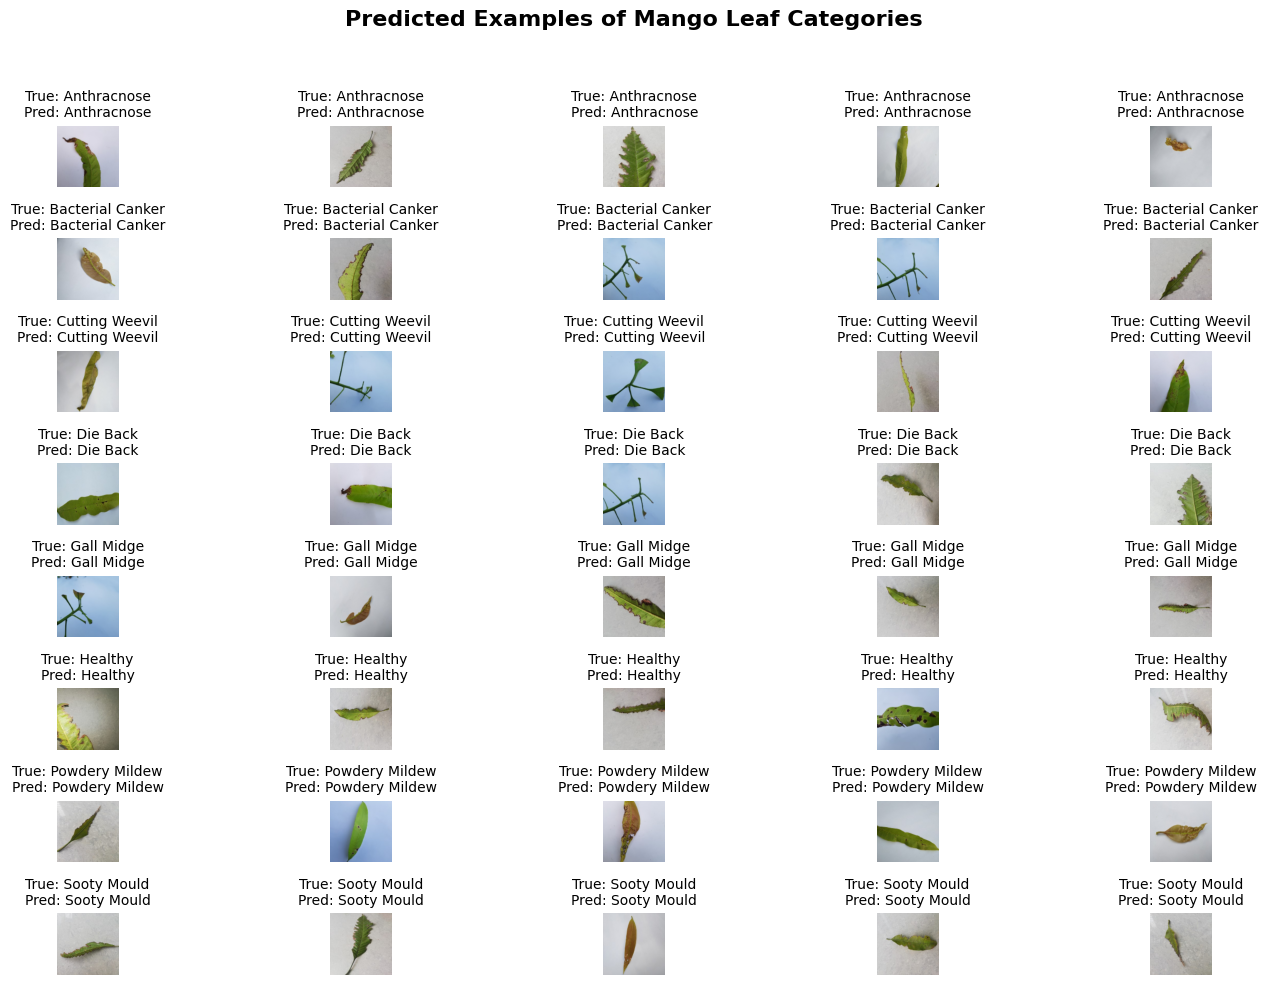

In [ ]:
def display_predicted_examples(model, X_test, y_test, categories, images, num_examples=5):

    y_pred = model.predict(X_test)

    plt.figure(figsize=(15, 10))
    plt.suptitle("Predicted Examples of Mango Leaf Categories", fontsize=16, fontweight='bold')

    for i, category in enumerate(categories):

        indices = [idx for idx in range(len(y_test)) if y_test[idx] == i and y_pred[idx] == i]

        sample_indices = random.sample(indices, min(num_examples, len(indices)))

        for j, idx in enumerate(sample_indices):

            plt.subplot(len(categories), num_examples, i * num_examples + j + 1)
            plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"True: {category}\nPred: {categories[y_pred[idx]]}", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

display_predicted_examples(rf_model, X_test, y_test, categories, images)


In [ ]:
#comparison
print("\nSummary Table:")
print(f"{'Model':<20} {'Accuracy':<10}")
print(f"{'-'*30}")
print(f"{'Decision Tree':<20} {dt_accuracy:<10.2f}")
print(f"{'Random Forest':<20} {rf_accuracy:<10.2f}")


Summary Table:
Model                Accuracy  
------------------------------
Decision Tree        0.68      
Random Forest        0.85      
